In [1]:
# Load packages
import numpy as np
import pandas as pd

In [2]:
# Load data
df = pd.read_csv("data/data_with_variables.csv")

### 1. Z-scaling before PCA

In [30]:
# z-scale the variables before PCA

print(df.shape)
print(property_data.shape)

(1046826, 45)
(1046826, 81)


In [31]:
save_record = property_data["RECORD"]

In [33]:
df = (df - df.mean()) / df.std()

### 2. Principal Component Analysis (PCA)

(0.0, 1.0)

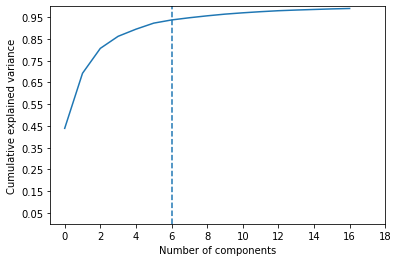

In [35]:
# PCA
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

pca = PCA(n_components=0.99, svd_solver="full")
pca.fit(df)
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel("Number of components")
plt.ylabel("Cumulative explained variance")
plt.yticks(np.arange(0.05, 1.1, step=0.1))
plt.xticks(np.arange(0, 20, step=2))
plt.axvline(x=6, linestyle="--")
plt.ylim(0, 1)

In [36]:
pca = PCA(n_components=6)
princ_comps = pca.fit_transform(df)
data_pca = pd.DataFrame(
    princ_comps, columns=["PC" + str(i) for i in range(1, pca.n_components_ + 1)]
)
data_pca.shape

(1046826, 6)

In [37]:
# Z-scale PC's
pca_mean = data_pca.mean()
pca_sd = data_pca.std()
data_pca = (data_pca - pca_mean) / pca_sd
data_pca.describe()

,PC1,PC2,PC3,PC4,PC5,PC6
count,1.046826e+06,1.046826e+06,1.046826e+06,1.046826e+06,1.046826e+06,1.046826e+06
mean,-5.608723e-16,-5.835700e-16,-2.938348e-16,-1.569305e-15,-3.177353e-15,-4.464063e-16
std,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00
min,-2.585169e-01,-2.280285e+02,-1.990058e+02,-2.023903e+02,-2.438864e+02,-2.002481e+02
25%,-1.088008e-01,-1.544611e-01,-1.356178e-01,-3.269411e-02,-1.159058e-01,-1.101849e-01
50%,-2.375699e-02,-5.919442e-02,6.964981e-04,1.366912e-02,-1.313774e-02,-2.535347e-02
75%,3.290240e-02,3.225958e-02,3.206016e-01,7.018405e-02,4.879424e-02,1.382286e-01
max,6.907817e+02,3.239819e+02,5.967327e+02,2.507935e+02,4.068851e+02,4.017187e+02


### Fraud Score 1: Z-score outliers

In [38]:
# Model 1: Z-score outliers
p = 2
one_over_p = 1 / p
score1 = (((data_pca).abs() ** p).sum(axis=1)) ** one_over_p

### Fraud Score 2: Autoencoder

In [39]:
# Model 2: Autoencoder

from keras.layers import Dense, Input
from keras.models import Model

# placeholder for input
data_in = Input(shape=(6,))

# dimension of the encoded data. Choose 3
encoded_dim = 3

# encoded representation of the data
encoded = Dense(encoded_dim, activation="tanh")(data_in)

# reconstruction of the input
decoded = Dense(6, activation="tanh")(encoded)

# this model maps the input data to the reconstructed data
autoencoder = Model(data_in, decoded)

autoencoder.compile(optimizer="adam", loss="mean_squared_error")

autoencoder.fit(
    data_pca, data_pca, epochs=3, shuffle=True, validation_data=(data_pca, data_pca)
)

pca_out = autoencoder.predict(data_pca)
error = pca_out - data_pca
p = 2
oop = 1 / p
score2 = ((error.abs() ** p).sum(axis=1)) ** oop

Epoch 1/3
32714/32714 [==============================] - 51s 2ms/step - loss: 1.2598 - val_loss: 0.8969
Epoch 2/3
32714/32714 [==============================] - 52s 2ms/step - loss: 0.8414 - val_loss: 0.8963
Epoch 3/3
32714/32714 [==============================] - 52s 2ms/step - loss: 1.0858 - val_loss: 0.8956


### Fraud Score 3: Average of Z-score and Autoencoder

In [40]:
# Make the final score as the average ranking
scores = pd.DataFrame(score1)
scores.columns = ["score1"]
scores["score2"] = score2
scores["score1 rank"] = scores["score1"].rank()
scores["score2 rank"] = scores["score2"].rank()
scores["final"] = (scores["score1 rank"] + scores["score2 rank"]) / 2

In [41]:
scores["RECORD"] = save_record
scores.set_index("RECORD", drop=True, inplace=True)

In [42]:
scores.sort_values("final", ascending=False).head(10)

,score1,score2,score1 rank,score2 rank,final
RECORD,,,,,
917942,981.327266,981.478957,1046826.0,1046826.0,1046826.0
684704,457.056846,455.326197,1046825.0,1046825.0,1046825.0
1065870,448.085896,446.689437,1046824.0,1046824.0,1046824.0
1059883,407.134142,405.359270,1046823.0,1046823.0,1046823.0
151044,396.025115,395.099898,1046822.0,1046822.0,1046822.0
39770,385.999662,384.643837,1046821.0,1046821.0,1046821.0
116647,368.262823,366.678761,1046820.0,1046819.0,1046819.5
12076,368.169072,367.047976,1046819.0,1046820.0,1046819.5
33751,343.450662,342.241478,1046818.0,1046818.0,1046818.0


In [43]:
data_orig = data_removed.iloc[:, :32]
data_orig.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1046826 entries, 0 to 1046825
Data columns (total 32 columns):
 #   Column    Non-Null Count    Dtype  
---  ------    --------------    -----  
 0   RECORD    1046826 non-null  int64  
 1   BBLE      1046826 non-null  object 
 2   B         1046826 non-null  int64  
 3   BLOCK     1046826 non-null  int64  
 4   LOT       1046826 non-null  int64  
 5   EASEMENT  2967 non-null     object 
 6   OWNER     1015081 non-null  object 
 7   BLDGCL    1046826 non-null  object 
 8   TAXCLASS  1046826 non-null  object 
 9   LTFRONT   1046826 non-null  int64  
 10  LTDEPTH   1046826 non-null  int64  
 11  EXT       353372 non-null   object 
 12  STORIES   1002858 non-null  float64
 13  FULLVAL   1046826 non-null  float64
 14  AVLAND    1046826 non-null  float64
 15  AVTOT     1046826 non-null  float64
 16  EXLAND    1046826 non-null  float64
 17  EXTOT     1046826 non-null  float64
 18  EXCD1     625308 non-null   float64
 19  STADDR    1046357 non

In [44]:
NY_data_with_scores = data_orig.join(
    scores[["score1 rank", "score2 rank", "final"]], on="RECORD"
)
NY_data_with_scores.set_index("RECORD", inplace=True)

In [45]:
top_records = NY_data_with_scores.sort_values("final", ascending=False).head(100)
top_records.to_csv("top_records.csv")

(0.1, 2088582.7348885664)

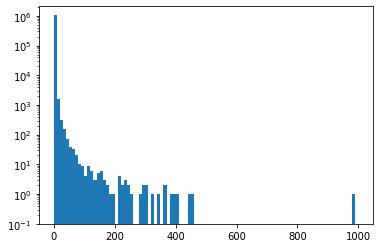

In [46]:
# Distribution of Score 1
plt.hist(score1, bins=100, range=(0, 1000))
plt.yscale("log")
plt.ylim(ymin=0.1)

(0.1, 2090075.5691957558)

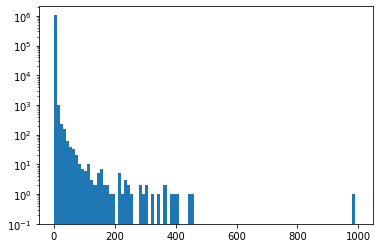

In [47]:
# Distribution of Score 2
plt.hist(score2, bins=100, range=(0, 1000))
plt.yscale("log")
plt.ylim(ymin=0.1)

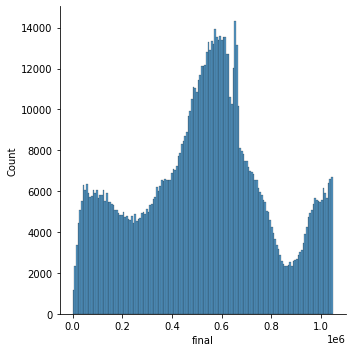

In [48]:
# Distribution of Final score
import seaborn as sns
sns.displot(scores["final"])